In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr 
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [2]:
df = yf.download(tickers = "EURUSD=X", period = "60d", interval = "1h", group_by = 'ticker', auto_adjust = True,
                   prepost = True, threads = True, proxy = None)
df['LogClose'] = np.log(df['Close'])
df['DiffLogClose'] = df['LogClose'].diff()

[*********************100%***********************]  1 of 1 completed


In [3]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

# Make supervised dataset
# let's see if we can use T past values to predict the next value
series = df['DiffLogClose'].to_numpy()[1:]

T = 21 
X = []
Y = []

for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (1394, 21) Y.shape (1394,)


In [14]:
series

array([-1.72387324e-03, -7.08914824e-04,  8.10332233e-04, ...,
       -1.84305106e-03,  1.35762333e-03,  9.70429837e-05])

In [4]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

lr = LinearRegression()
lr.fit(Xtrain,Ytrain)
print(lr.score(Xtrain, Ytrain))
print(lr.score(Xtest,Ytest))

0.017674300587835146
-0.08375328739243026


In [5]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable

# Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

# last-Known train value 
last_train = train.iloc[-1]['LogClose']


In [6]:
prev[test_idx]

2022-10-10 00:00:00+01:00   -0.026058
2022-10-10 01:00:00+01:00   -0.026545
2022-10-10 02:00:00+01:00   -0.026350
2022-10-10 03:00:00+01:00   -0.024985
2022-10-10 04:00:00+01:00   -0.025473
2022-10-10 05:00:00+01:00   -0.026350
2022-10-10 06:00:00+01:00   -0.026155
2022-10-10 07:00:00+01:00   -0.028393
2022-10-10 08:00:00+01:00   -0.028393
2022-10-10 09:00:00+01:00   -0.029559
2022-10-10 10:00:00+01:00   -0.031402
2022-10-10 10:24:49+01:00   -0.030044
Name: ShiftLogClose, dtype: float64

In [7]:
lr.predict(Xtest)

array([ 1.89815061e-05,  9.43306840e-05,  8.39279357e-05,  4.82243393e-05,
        1.19270389e-05, -1.11583802e-04, -2.72343553e-05,  3.92569878e-04,
        1.01528326e-04,  1.62340295e-04,  4.47983714e-04, -2.16365250e-04])

<AxesSubplot:>

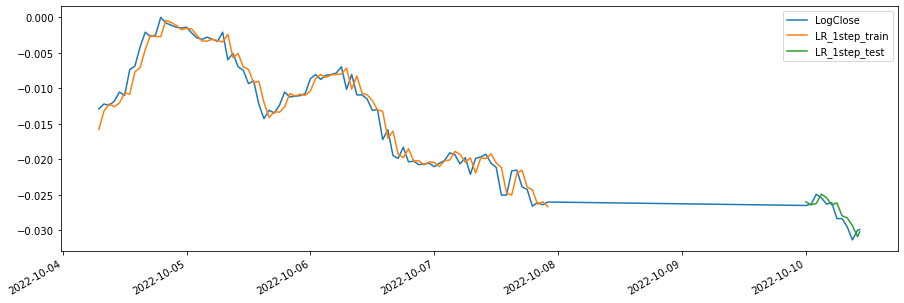

In [8]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

# plot 1-step forecast 
cols = ['LogClose', 'LR_1step_train', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5))

In [9]:
df.iloc[-12:]['LR_1step_test']

2022-10-10 00:00:00+01:00   -0.026039
2022-10-10 01:00:00+01:00   -0.026450
2022-10-10 02:00:00+01:00   -0.026266
2022-10-10 03:00:00+01:00   -0.024937
2022-10-10 04:00:00+01:00   -0.025461
2022-10-10 05:00:00+01:00   -0.026461
2022-10-10 06:00:00+01:00   -0.026182
2022-10-10 07:00:00+01:00   -0.028001
2022-10-10 08:00:00+01:00   -0.028292
2022-10-10 09:00:00+01:00   -0.029396
2022-10-10 10:00:00+01:00   -0.030954
2022-10-10 10:24:49+01:00   -0.030261
Name: LR_1step_test, dtype: float64

<AxesSubplot:>

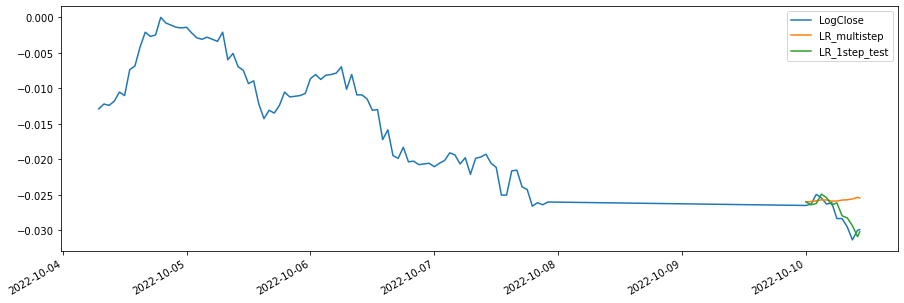

In [10]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
   p = lr.predict(last_x.reshape(1,-1))[0]
    
  # Update the predictions list
   multistep_predictions.append(p)
    
  # make the new input
   last_x = np.roll(last_x, -1)
   last_x[-1] = p 

# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)
 
# plot 1-step and multi-step forecast
cols = ['LogClose', 'LR_multistep', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5))

In [11]:
# make multi-output supervised dataset 
Tx = T 
Ty = Ntest
X = []
Y = []
for t in range(len(series)-Tx-Ty+1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (1383, 21) Y.shape (1383, 12)


0.01720215602690514
-56.26097721389661


<AxesSubplot:>

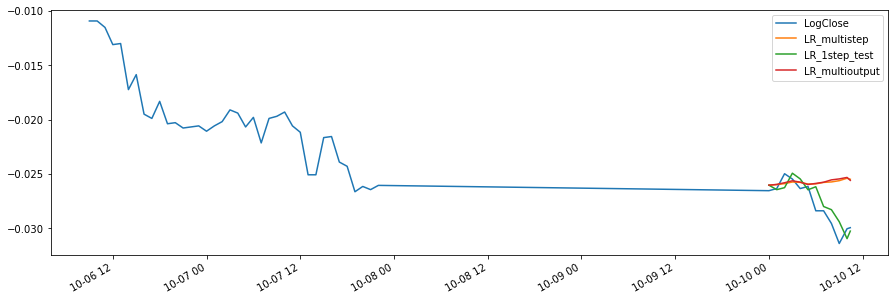

In [12]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
print(lr.score(Xtrain_m, Ytrain_m))
print(r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten()))

# save multi_output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = last_train + \
  np.cumsum(lr.predict(Xtest_m).flatten())

# plot all forecasts
cols = ['LogClose', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df.iloc[-50:][cols].plot(figsize=(15,5))

In [13]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx,'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_1step_test'])
print("LR_1step_test MAPE:", mape3)

multi-step MAPE: 0.07548521874035202
multi-output MAPE: 0.07587877941142375
LR_1step_test MAPE: 0.031649040849014515
